In [20]:
import math

In [215]:



class Value:
    def __init__(self, val, _parents=(), _op='', _label='value'):
        
        self.val = val
        self._prev = set(_parents)
        self._op = _op
        self.grad = 0.0
        self._label = _label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(val={self.val}, label={self._label})"

    def __add__(self, another_value):
        result = self.val + another_value.val
        out = Value(result, _parents=(self, another_value), _op='+')
        
        #Define function for backprop for sum
        def _backward():
            
            self.grad = out.grad
            another_value.grad = out.grad
        
        self._backward = _backward
        
        
        return out

    def __mul__(self, another_value):

        result = self.val * another_value.val
        out = Value(result, _parents=(self, another_value), _op='*')
        
        def _backward():
            self.grad = another_value.val * out.grad
            another_value.grad = self.val * out.grad
            
        self._backward = _backward
        

        return out
    
    def tanh(self):
        val = (math.exp(2 * self.val) - 1) / (math.exp(2 * self.val) + 1)
        
        out = Value(val, _parents=(self, ), _op='tanh')
        
        def _backward():
            self.grad =  (1 - out.val ** 2) * out.grad
            
        self._backward = _backward
        
        return out
    
    def backward(self):
        
        self.grad = 1
        
        topo = []
        visited = set()

        #Topological sorting
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for parent in v._prev:
                    build_topo(parent)
                topo.append(v)
        
        build_topo(self)
        
        #go through node and call _backward()
        for node in reversed(topo):
            node._backward()


In [216]:
a = Value(0.4, _label="a")
b = Value(3, _label="b")
d = Value(0.3, _label="d")

c = a * b; c._label="c"
k = c * d; k._label="k"

inter = k.tanh(); inter._label = "inter"

final = inter.tanh() * Value(2)

**Visualizing computational graph**

In [205]:
# brew install graphviz
#pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s %.4f | grad %.2f}" % (n._label, n.val, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

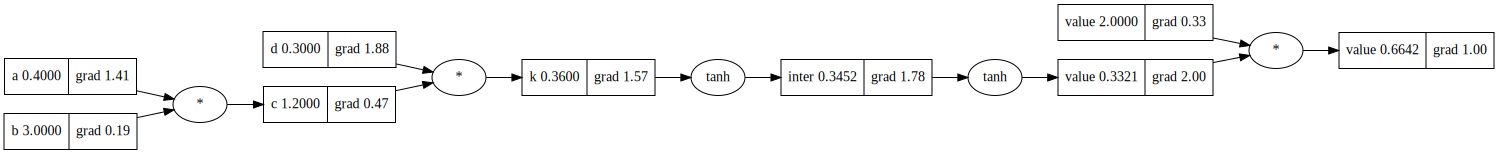

In [218]:

draw_dot(final)

In [217]:
final.backward()

        